In this notebook I compare the models we selected applied to the small aoi samples. (needs to be moved to main folder to access sample_rasters functions)

In [1]:
import os
import pandas as pd
import numpy as np

import rioxarray as rioxr

from sklearn.ensemble import RandomForestClassifier

from joblib import load

import matplotlib.pyplot as plt
import matplotlib.image

import A_data_sampling_workflow.sample_rasters as sr

from shapely.geometry import Polygon

In [2]:
def classify_iceplant(raster, rfc, cols):
    """ applies a given RFC model to the vegetation in a raster
    
    After selecting the pixels in raster most likely to be vegetation (ndwi<0.3 and ndvi>0.05), 
    it applies the given rfc to classify those pixels. 

    Parameters:
    ----------
    raster : 
        4-band raster with r,g,b,nir bands, not too big
    rfc : 
        binary random forest classification model
    cols : list
        names of the features that will be used in the classification
        must be a subset of ['r','g','b','nir'], the spectral bands of raster
        
    Return:
    -------
    An array of the same length and width as input raster with three classes:
        negative classification on vegetation [raster value 0], 
        positive classification on vegetation [raster value 1], and 
        non-vegetation [raster value 3],
        other [raster value 100]
    """
    # ---------------------------------------
    # find vegetation pixels to go into model
    # keep indices of water and low-ndvi pixels
    # add ndvi and ndwi features for each pixel 
    is_veg, water_index, not_veg_index = sr.add_spectral_features(
        df = sr.raster_as_df(raster.to_numpy(), ['r','g','b','nir']), #names of bands
        ndwi_thresh = 0.3, 
        ndvi_thresh = 0.05) 
    # ---------------------------------------
    # select features
    is_veg.drop('ndwi', axis=1, inplace=True)
    classify = is_veg[cols].to_numpy()
    # ---------------------------------------
    # predict using model
    preds = rfc.predict(classify)    
    # ---------------------------------------
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(preds, 
                         columns=['is_iceplant'], 
                         index = is_veg.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()
    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    # values assigned to pixels from each index
    values = [0,    
              1,
              3,   
              3]
    reconstruct = sr.indices_to_image(raster.shape[1], 
                                      raster.shape[2], 
                                      indices, values, 
                                      back_value=100)
    return reconstruct

In [3]:
def classify_iceplant_texture(raster, rfc, cols, entropy_r):
    """ applies a given RFC model to the vegetation in a raster taking into account texture features
    
    After selecting the pixels in raster most likely to be vegetation (ndwi<0.3 and ndvi>0.05), 
    it applies the given rfc to classify those pixels using spectral, date, NDVI, and texture information.

    Parameters:
    ----------
    raster : 
        4-band raster with r,g,b,nir bands, not too big
        
    rfc : 
        binary random forest classification model
        
    cols : list
        names of the features that will be used in the classification
        must be a subset of ['r','g','b','nir'
        
    entropy_r : 
        
        
    Return:
    -------
    An array of the same length and width as input raster with three classes:
        negative classification on vegetation [raster value 0], 
        positive classification on vegetation [raster value 1], and 
        non-vegetation [raster value 3].
    """
    
    box_side = entropy_r *2 +1
    # ***********************************************************************************************
    # *************************************** PRE-PROCESSING ****************************************

    # find vegetation pixels to go into model
    # keep indices of water and low-ndvi pixels
    # add ndvi and ndwi features for each pixel
    is_veg, water_index, not_veg_index = sr.add_spectral_features(
        df=sr.raster_as_df(raster.to_numpy(), ['r','g','b','nir']), #names of bands
        ndwi_thresh = 0.3, 
        ndvi_thresh = 0.05) 

    # ---------------------------------------
    # discard ndwi and add date features
    is_veg.drop('ndwi', axis=1, inplace=True)
    is_veg = sr.add_date_features(is_veg, raster.datetime)

    # ******************************** CREATE R,G,B,NIR AUXILIARY RASTERS *****************************
    # make auxiliary spectral rasters from clipped NAIP 
    band_names = ['r_', 'g_', 'b_', 'nir_']
    tags = ['_avgs', '_entrs']
    window_fps = []
    window_cols = []

    for name, band in zip(band_names,range(1,5)):
        rast_name = name+itemid

        for tag in tags:
            rast_fp = os.path.join(os.getcwd(), 'temp', rast_name + tag + '.tif')
            window_fps.append(rast_fp)        
            window_cols.append( name.replace('_','')+tag.replace('s',str(box_side)))

            if os.path.isfile(rast_fp) == False:
                if tag == '_avgs':
                    sr.avg_raster(raster = raster, band=band, rast_name=rast_name, n=box_side)                            
                elif tag == '_entrs':
                    sr.entropy_raster(raster=raster, band=band, rast_name=rast_name, n=entropy_r)

    # ******************************** CREATE NDVI AUXILIARY RASTERS *****************************
    # make auxiliary NDVI from clipped NAIP 
    ndvi = sr.ndvi_xarray(raster)
    band_names.append('ndvi_')
    rast_name = 'ndvi_'+itemid

    for tag in tags:
        rast_fp = os.path.join(os.getcwd(), 'temp', rast_name + tag + '.tif')
        window_fps.append(rast_fp)        
        window_cols.append('ndvi' + tag.replace('s',str(box_side)))                

        if os.path.isfile(rast_fp) == False:
            if tag == '_avgs':
                sr.avg_raster(rast_data=ndvi, 
                              crs=raster.rio.crs, 
                              transf=raster.rio.transform(), 
                              rast_name=rast_name, 
                              n=box_side)
            elif tag == '_entrs':
                # adjusting to entropy input types
                ndvi = ndvi*100+100  
                sr.entropy_raster(rast_data=ndvi.astype('uint8'), 
                                  crs=raster.rio.crs, 
                                  transf=raster.rio.transform(), 
                                  rast_name=rast_name, 
                                  n=entropy_r)

    # ************** EXTRACT FEATURES FROM AUXILIARY RASTERS *********************
    window_values = []    
    for fp_aux in window_fps:
        match = rioxr.open_rasterio(fp_aux).squeeze()
        match_vector = match.to_numpy().reshape(match.shape[0]*match.shape[1])
        window_values.append(match_vector)
        # delete_aux_rasters
        os.remove(fp_aux)

    df_window = pd.DataFrame(dict(zip( window_cols, window_values)))

    scene_features = pd.concat([is_veg, df_window.iloc[is_veg.index]], axis=1)

    # **** REMOVE NA VALUES (PIXELS AT EDGE OF CLIPPED PART OF RASTER) ***
    # combine indices for r_min == 0 and ndvi_min == nan, ndvi_avg == nan

    # **** THIS NEEDS TO BE NOT HARDCODED: r_min11 and ndvi_min11 ****
    remove = set()
    if '_min' in tags:
        remove = scene_features.r_min11[scene_features.r_min11 == 0].index
    for band in [x.replace('s',str(box_side)) for x in ['ndvi'+ y for y in tags]]:
        remove = remove.union(scene_features[band][scene_features[band].isna() == True].index)
    # remove these indices from scene_features
    # no need to add them anywhere else, they will be part of the raster's background
    scene_features = scene_features.drop(remove)

    # *********************** ORDER FEATURES ****************************** 

    scene_features = scene_features[cols]

    # ************************ CLASSIFICATION ******************************
    #  predict using model
    scene_preds = rfc.predict(np.array(scene_features))

    # ************************ POST-PROCESSING *****************************
    # recover pixel indices for iceplant classifications
    preds_df = pd.DataFrame(scene_preds, 
                         columns=['is_iceplant'], 
                         index = scene_features.index)
    is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
    non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

    # ---------------------------------------
    # reconstruct indices into image
    indices = [non_iceplant_index,
               is_iceplant_index, 
               not_veg_index,
               water_index]
    values = [0,    # values assigned to pixels from each index
              1,
              3,
              3]
    reconstruct = sr.indices_to_image(raster.shape[1], 
                                      raster.shape[2], 
                                      indices, 
                                      values, 
                                      back_value=100)

    return reconstruct

In [4]:
# =====================================================
# Conception
box_conc = Polygon([
            [-120.460475016992,34.458719091893286],
            [-120.460475016992,34.457914336783816],
            [-120.4595085784309,34.457914336783816],
            [-120.4595085784309,34.458719091893286],
            [-120.460475016992,34.458719091893286]
          ])

itemid_conc = 'ca_m_3412037_nw_10_060_20200607'
# =====================================================
# Downtown Santa Barbara
box_dtwn = Polygon([
            [-119.68421454977785,34.41470061879498],
            [-119.68421454977785,34.413873204306356],
            [-119.68319471307942,34.413873204306356],
            [-119.68319471307942,34.41470061879498],
            [-119.68421454977785,34.41470061879498]
          ])
itemid_dtwn = 'ca_m_3411935_se_11_060_20200521'

# =====================================================
# Carpinteria

box_carp = Polygon( [
            [-119.5144546684841,34.39274397377842],
            [-119.5144546684841,34.39193499538564],
            [-119.51344346289721,34.39193499538564],
            [-119.51344346289721,34.39274397377842],
            [-119.5144546684841,34.39274397377842]
          ])
itemid_carp = 'ca_m_3411936_se_11_060_20200521'

# =====================================================
# Campus lagoon

box_campus = Polygon([
            [-119.84498486537822,34.405839218897256],
            [-119.84498486537822,34.40505175972115],
            [-119.84395933515827,34.40505175972115],
            [-119.84395933515827,34.405839218897256],
            [-119.84498486537822,34.405839218897256]
          ])
itemid_campus = 'ca_m_3411934_sw_11_060_20200521'

In [5]:
# **************************************************************
# TRAIN MODELS: spectral, 13x13, and salt13_p30
# **************************************************************

# **************************************************************
# MODELS WITH INITIAL TRAINING DATA: spectral + 13x13

# open initial training data
root = '/home/jovyan/msai4earth-esa/iceplant_detection/data/INITIAL_DATASET/'
train_name = 'train_2500.csv'

X_train = pd.read_csv(os.path.join(root, train_name))
y_train = pd.read_csv(os.path.join(root, train_name)).loc[:,'iceplant'] 
y_train = y_train.to_numpy()

# ------------------------------
# spectral model: only uses raster's spectral bands
bands = ['r','g','b','nir']
X_train_sub = X_train[bands].to_numpy()

rfc_spectral = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc_spectral.fit(X_train_sub, y_train)

# ------------------------------
# 13x13 model: uses spectral, ndvi, date, average and entropy features over a 13x13 window
box_s = 13
window_features = [band + x + str(box_s) for band in bands+['ndvi'] for x in ['_avg', '_entr']]
cols_13x13 =  bands + ['ndvi'] + window_features + ['month', 'day_in_year']

X_train_sub = X_train[cols_13x13].to_numpy()

rfc_13x13 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc_13x13.fit(X_train_sub, y_train)
    
# **************************************************************
# MODEL WITH EXTENDED DATA: salt13_p30 model

# open extended dataset
root = '/home/jovyan/msai4earth-esa/iceplant_detection/data/EXTENDED_DATASET_salt13_p30/'
train_name = 'salt13_p30_train.csv'

X_train_salt = pd.read_csv(os.path.join(root, train_name))
y_train_salt = pd.read_csv(os.path.join(root, train_name)).loc[:,'iceplant'] 
y_train_salt = y_train_salt.to_numpy()

# ------------------------------
# features
cols_salt = ['r', 
        'r_avg13', 'r_entr13',         
        'g',
        'g_avg13', 'g_entr13',                 
        'b',
        'b_avg13', 'b_entr13',                 
        'nir',
        'nir_avg13', 'nir_entr13',                 
        'ndvi',
        'ndvi_avg13', 'ndvi_entr13',        
        'month', 
        'day_in_year']

# ------------------------------
# train 
X_train_sub = X_train_salt[cols_salt].to_numpy()

rfc_salt = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc_salt.fit(X_train_sub, y_train_salt)

# **************************************************************
rfcs = [rfc_spectral, rfc_13x13, rfc_salt]

In [6]:
def save_images(prefix, folder, images):
    """saves the rasters in rasters as .png images, each raster has bands R,G,B, NIR"""

    i = 0
    for image in images:
        fn = prefix+'_'+str(i)+'.png'
        matplotlib.image.imsave(folder+fn, image)
        i+=1
    return

# save images of aois
folder = os.path.join(os.getcwd(),
             'E_comparing_models',
             'images_comparison',
             'images_comparison_spectral_13x13_salt13_models/')

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


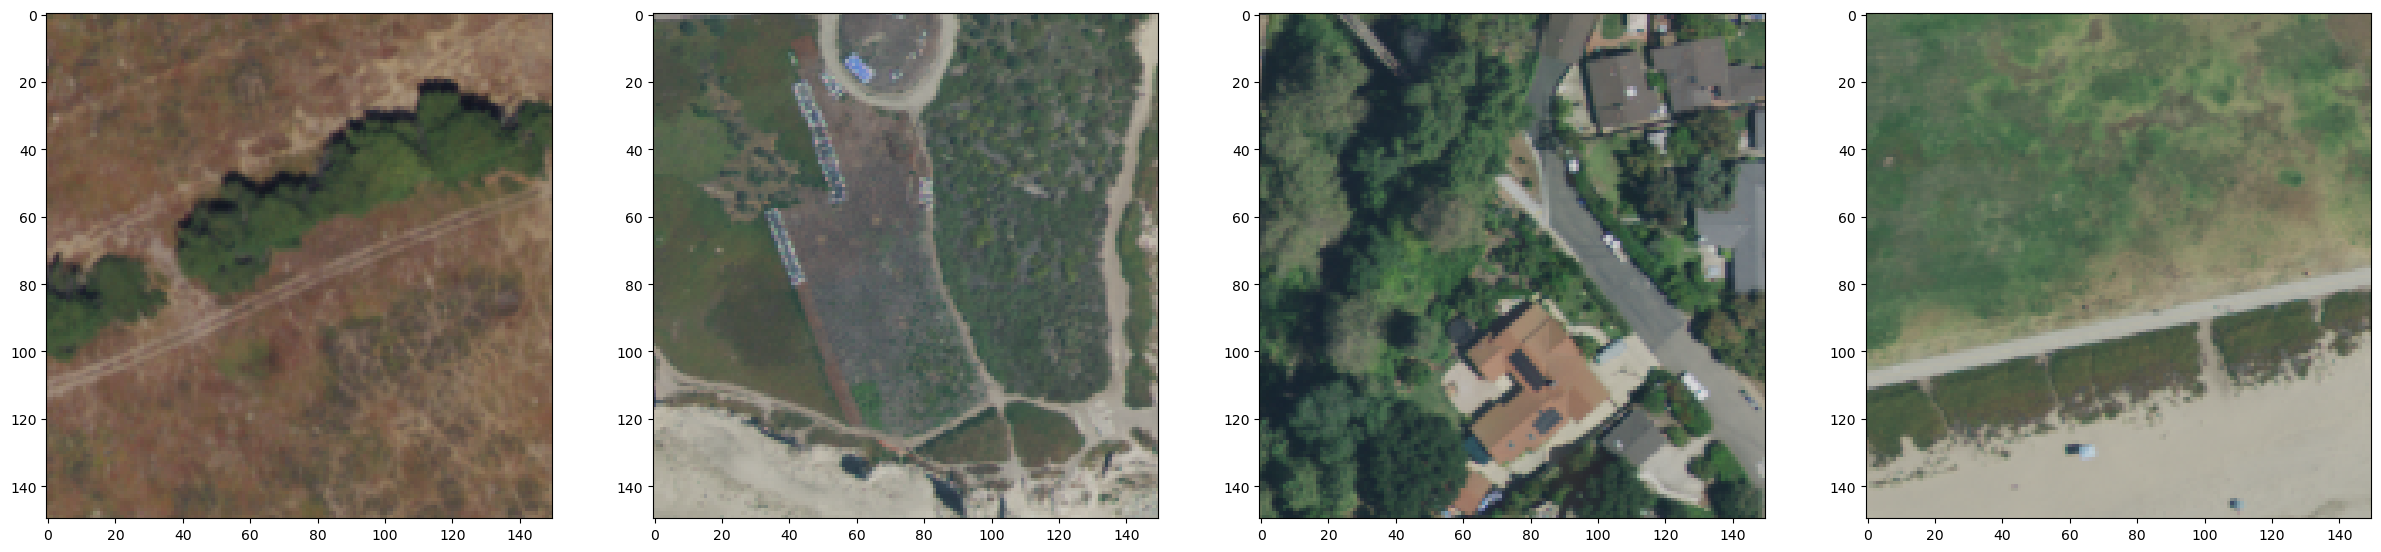

In [7]:
# Load rasters

boxes = [box_conc, box_campus, box_carp, box_dtwn]
itemids = [itemid_conc, itemid_campus, itemid_carp, itemid_dtwn]


# I had already checked these aois are at least 150x150 pixels
rasters = []
for itemid, box in zip(itemids, boxes):
    rasters.append(sr.rioxr_from_itemid(itemid, box, "EPSG:4326")[:,0:150,0:150])
    # the second subset is selecting the region outside a 15 pixel buffer around all edges

# for plotting we will need a smaller region within the raster
inner_rasters = [raster[:,16:136,16:136] for raster in rasters]

# save images
i = 0
for raster in inner_rasters:
    fn = 'aoi_'+str(i)+'.png'
    matplotlib.image.imsave(folder+fn, 
                            np.moveaxis(raster.loc[1:3].to_numpy(),0,-1))
    i+=1

# plot complete aois
fig, ax = plt.subplots(1,4,figsize=(30, 20))  
for i in range(4):
    ax[i].imshow(np.moveaxis(rasters[i].loc[1:3].to_numpy(),0,-1))
plt.show()

In [8]:
images = []

# images for spectral model
this_model_imgs =[]
for raster in rasters:
    # match with inner raster for the 13x13 and salt models
    this_model_imgs.append(classify_iceplant(raster, rfc_spectral, bands)[16:136,16:136])
images.append(this_model_imgs)

save_images('spectral', folder, this_model_imgs)

In [10]:
for rfc, cols_names, label in zip([rfc_13x13, rfc_salt],
                                  [cols_13x13, cols_salt],
                                  ['texture_13x13','salt13_p30']):

    this_model_imgs = []
    for raster in rasters:
        this_model_imgs.append(classify_iceplant_texture(raster, rfc, cols_names, 6)[16:136,16:136])

    images.append(this_model_imgs)
    save_images(label, folder, this_model_imgs)

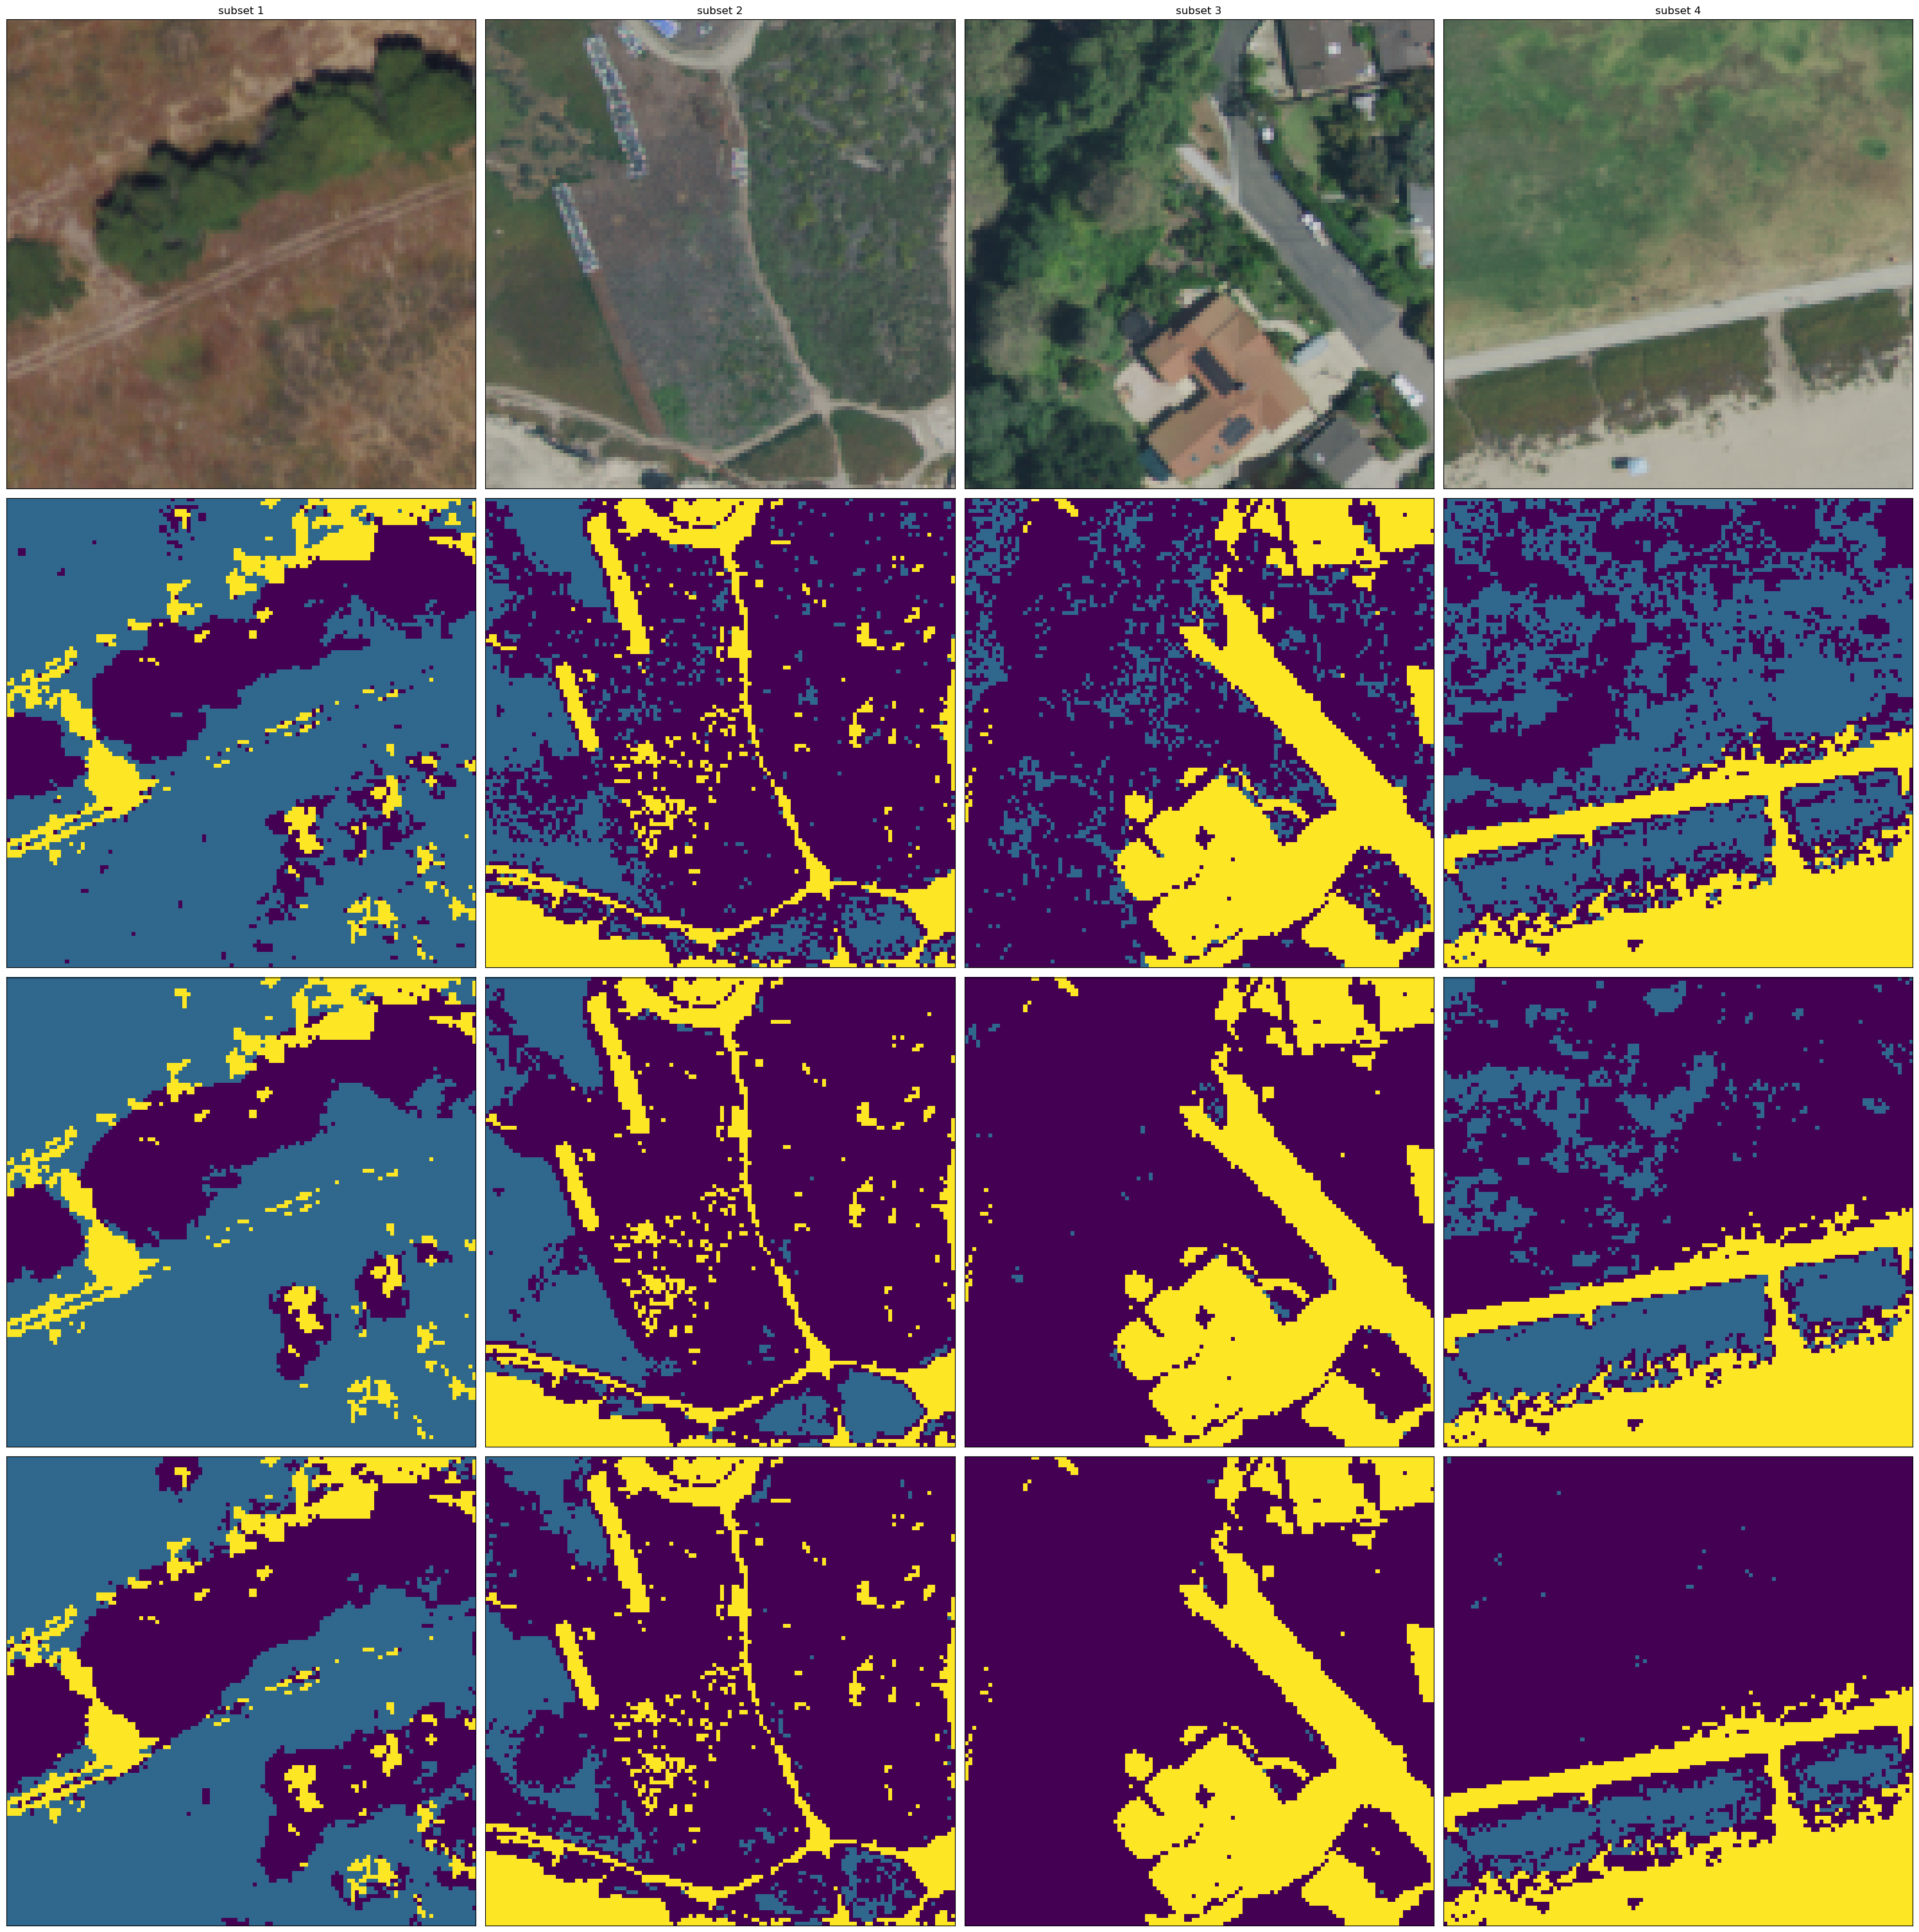

In [11]:
n = 3
fig, axes = plt.subplots(n+1,len(inner_rasters), figsize=(30,30))
plt.setp(axes, xticks=[], yticks=[])
fig.subplots_adjust(hspace=0.2)
plt.tight_layout()
# for i in range(2):
#     for j in range(4):
#         axes[i][j].set_aspect('equal')

for j in range(len(rasters)):
    axes[0,j].imshow(np.moveaxis(inner_rasters[j].loc[1:3].to_numpy(),0,-1))
    axes[0,j].set_title('subset ' + str(j+1))

#for i, title in zip(range(len(radii)), feats):
#for i in range(len(radii)):
for i in range(n):
    for j in range(len(inner_rasters)):
        axes[i+1,j].imshow(images[i][j])
    #        axes[i+1,j].set_title(title)


plt.savefig('selected_models_image_comparisons.png', bbox_inches='tight')
plt.show()